In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**IMPORTING THE NECESSARY LIBRARIES**


In [1]:
#Import Libraries =======================================
# !pip install segmentation_models_pytorch
from typing import Optional, List
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import albumentations as A
import segmentation_models_pytorch as smp

In [2]:
print(torch.__version__)

1.9.0+cu102


**Required Paths for Data**


In [4]:
ROOT = '/content/drive/MyDrive/OriginData'
trainpath = "/content/drive/MyDrive/OriginData/train"
valpath = "/content/drive/MyDrive/OriginData/val"
testpath = "/content/drive/MyDrive/OriginData/test"

os.chdir(ROOT)
train_imgs = [os.path.join(trainpath,'images',i) for i in sorted(os.listdir(os.path.join(trainpath,'images')))]
train_masks = [os.path.join(trainpath,'labels',i) for i in sorted(os.listdir(os.path.join(trainpath,'labels'))) if "_Annotation" in i]

df_train = pd.DataFrame({"image":train_imgs,"mask":train_masks})
df_train.to_csv('train.csv')

val_imgs = [os.path.join(valpath,'images',i) for i in sorted(os.listdir(os.path.join(valpath,'images')))]
val_masks = [os.path.join(valpath,'labels',i) for i in sorted(os.listdir(os.path.join(valpath,'labels'))) if "_Annotation" in i]

df_val = pd.DataFrame({"image":val_imgs,"mask":val_masks})
df_val.to_csv('val.csv')

test_imgs = [os.path.join(testpath,'images',i) for i in sorted(os.listdir(os.path.join(testpath,'images')))]
test_names = [i for i in sorted(os.listdir(os.path.join(testpath,'images')))]
df_test = pd.DataFrame({"image":test_imgs,"image_names":test_names})
df_test.to_csv('test.csv')

**Dataset Class**


In [5]:
# Subclass and define custom dataset ===========================
#Dataset Class
class MultiClassSegDataset(Dataset):
    
    def __init__(self, df, classes=None, transform=None,):
        self.df = df
        self.classes = classes
        self.transform = transform
    
    def __getitem__(self, idx):
        
        image_name = self.df.iloc[idx, 1]
        mask_name = self.df.iloc[idx, 2]
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_name, cv2.IMREAD_UNCHANGED)
        image = image.astype('uint8')
        mask = mask[:,:]
        if(self.transform is not None):
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)   
            image = image.permute(2, 0, 1)
            image = image.float()/255
            mask = mask.long().unsqueeze(0)
        else: 
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)
            image = image.permute(2, 0, 1)
            image = image.float()/255
            mask = mask.long().unsqueeze(0)
        return image, mask  
        
    def __len__(self):
        return len(self.df)

## HYPERPARAMETERS

In [9]:
# Define Variables ========================================
#HYPERPARAMETERS
MULTICLASS_MODE: str = "multiclass"
ENCODER = "resnet50"   #resnet50, vgg16, efficientnet-b4, xception, mobilenet_v2
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['background', 'CRANIUM', 'MIDLINE_FALX', 'CSP', 'CHORID_PLEXUS', 'BRAIN_PARENCHYMA']
ACTIVATION = None
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 10
LEARNING_RATE = 0.001

TRANSFORMATIONS

In [6]:
#Define tranforms using Albumentations =======================================
val_transform = A.Resize(256, 256)

test_transform = A.Resize(256,256)

train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256, border_mode=4),
        A.Resize(256, 256),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.MedianBlur(blur_limit=3, always_apply=False, p=0.1),
    ]
)

In [11]:
# Change directory
os.chdir(ROOT)

#Read files =======================================
train = pd.read_csv("/content/drive/MyDrive/OriginData/train.csv")
val = pd.read_csv("/content/drive/MyDrive/OriginData/val.csv")
test = pd.read_csv("/content/drive/MyDrive/OriginData/test.csv")


# Create the datasets   ================================================ 
trainDS = MultiClassSegDataset(train, classes=CLASSES, transform=train_transform)
valDS = MultiClassSegDataset(val, classes=CLASSES, transform=val_transform)
print("Number of Training Samples: " + str(len(train)-1) + "\n" + "Number of Validation Samples: " + str(len(test)))

# Define DataLoaders ==============================================
trainDL = torch.utils.data.DataLoader(trainDS, batch_size=4, shuffle=True, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
valDL =  torch.utils.data.DataLoader(valDS, batch_size=4, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

Number of Training Samples: 59
Number of Validation Samples: 13


In [12]:
# Check Tensor shapes ======================================================
batch = next(iter(trainDL))
images, labels = batch
print(images.shape, labels.shape, type(images), type(labels), images.dtype, labels.dtype)

torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256]) <class 'torch.Tensor'> <class 'torch.Tensor'> torch.float32 torch.int64


In [13]:
# Check first sample from patch =================================================
testImg = images[1]
testMsk = labels[1]
print(testImg.shape, testImg.dtype, type(testImg), testMsk.shape, 
testMsk.dtype, type(testMsk), testImg.min(), 
testImg.max(), testMsk.min(), testMsk.max())

torch.Size([3, 256, 256]) torch.float32 <class 'torch.Tensor'> torch.Size([1, 256, 256]) torch.int64 <class 'torch.Tensor'> tensor(0.) tensor(0.6431) tensor(0) tensor(5)


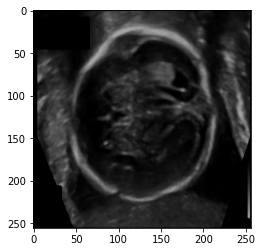

In [14]:
# Plot example image =====================================
plt.imshow(testImg.permute(1,2,0))
plt.show()

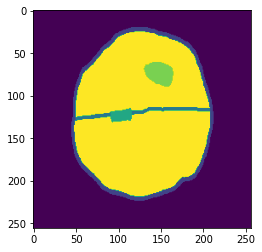

In [15]:
# Plot exmaple mask ======================================
plt.imshow(testMsk.squeeze(0))
plt.show()

MODEL WITH PRETRAINED WEIGHTS

In [16]:
# Initiate UNet++ Model ======================================
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=3,
    classes=6,
    activation=ACTIVATION,
)

#Define Loss and Metrics to Monitor (Make sure mode = "multiclass") ======================================
loss = smp.losses.DiceLoss(mode="multiclass")
loss.__name__ = 'Dice_loss'

metrics = []
# Define Optimizer and learning rate ============================
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Define training epoch =====================================
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss,
    metrics= metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

# Define validation epoch =====================================
val_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

TRAINING

In [17]:
# Train model for 10 epochs ==================================
max_score = 0
EPOCHS = 10
train_losses, val_losses = [], []
dice_train, dice_val = [], []
for i in range(EPOCHS):
    print(f"EPOCH {i+1}")
    train_logs = train_epoch.run(trainDL)
    val_logs = val_epoch.run(valDL)
    train_losses.append(train_logs['Dice_loss'])
    val_losses.append(val_logs['Dice_loss'])
    dice_train.append(1 - train_logs['Dice_loss'])
    dice_val.append(1 - val_logs['Dice_loss'])
    model_name = './model-' + ENCODER + '-.pth'
    torch.save(model, model_name)

EPOCH 1
train:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


valid: 100%|██████████| 3/3 [00:00<00:00,  8.03it/s, Dice_loss - 0.6972]
EPOCH 2
valid: 100%|██████████| 3/3 [00:00<00:00,  7.90it/s, Dice_loss - 0.5424]
EPOCH 3
valid: 100%|██████████| 3/3 [00:00<00:00,  8.01it/s, Dice_loss - 0.4068]
EPOCH 4
valid: 100%|██████████| 3/3 [00:00<00:00,  7.53it/s, Dice_loss - 0.3218]
EPOCH 5
valid: 100%|██████████| 3/3 [00:00<00:00,  7.59it/s, Dice_loss - 0.2333]
EPOCH 6
valid: 100%|██████████| 3/3 [00:00<00:00,  7.67it/s, Dice_loss - 0.236]
EPOCH 7
valid: 100%|██████████| 3/3 [00:00<00:00,  6.62it/s, Dice_loss - 0.1944]
EPOCH 8
valid: 100%|██████████| 3/3 [00:00<00:00,  7.87it/s, Dice_loss - 0.2253]
EPOCH 9
valid: 100%|██████████| 3/3 [00:00<00:00,  7.65it/s, Dice_loss - 0.2147]
EPOCH 10
valid: 100%|██████████| 3/3 [00:00<00:00,  6.63it/s, Dice_loss - 0.2037]


PLOTTING THE SCORE AND LOSS


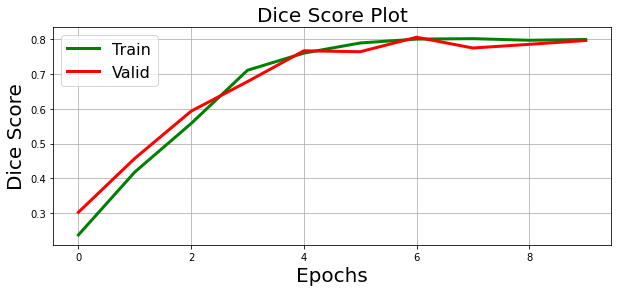

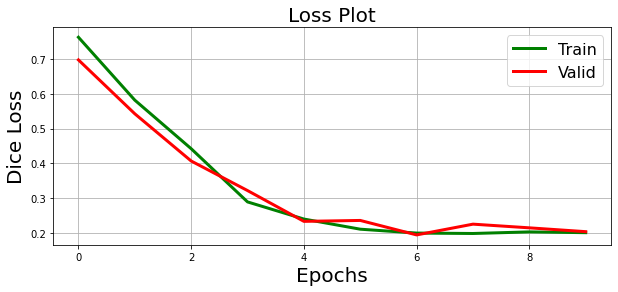

In [26]:
plt.figure(figsize=(10,4))
plt.plot(dice_train,'g-',lw=3, label = 'Train')
plt.plot(dice_val,'r-',lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Score', fontsize=20)
plt.title('Dice Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(train_losses,'g-',lw=3, label = 'Train')
plt.plot(val_losses,'r-',lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

In [19]:
#DICE SCORE CALCULATION

print('Training Dice Score:',max(dice_train))
print('Validation Dice Score:', max(dice_val))

Training Dice Score: 0.8014934887488684
Validation Dice Score: 0.8055974145730337


In [20]:
#LOAD THE MODEL
best_model = torch.load('/content/drive/MyDrive/OriginData/model-resnet50-.pth') 

In [21]:
# Subclass and define custom dataset for test images ===========================
class TestDataset(Dataset):
    
    def __init__(self, df, classes=None, transform=None,):
        self.df = df
        self.classes = classes
        self.transform = transform
    
    def __getitem__(self, idx):
        
        image_name = self.df.iloc[idx, 2]
        image_path = self.df.iloc[idx, 1]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype('uint8')
        if(self.transform is not None):
            transformed = self.transform(image=image)
            image = transformed["image"]
            image = torch.from_numpy(image)   
            image = image.permute(2, 0, 1)
            image = image.float()/255
        else: 
            image = torch.from_numpy(image)
            image = image.permute(2, 0, 1)
            image = image.float()/255
        return image, image_name
        
    def __len__(self):
        return len(self.df)

In [22]:
testDS = TestDataset(test, classes=CLASSES, transform=test_transform)
#DATALOADER FOR TEST IMAGES
testDL =  torch.utils.data.DataLoader(testDS, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

batch = next(iter(testDL))
images, image_name = batch
print(images.shape, type(images), images.dtype)
print(image_name)

torch.Size([1, 3, 256, 256]) <class 'torch.Tensor'> torch.float32
('197_HC.png',)


In [23]:
#HELPER FUNCTIONS

#Visualize images, masks, and predictions=======================================

def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

PLOTTING VALIDATION IMAGES

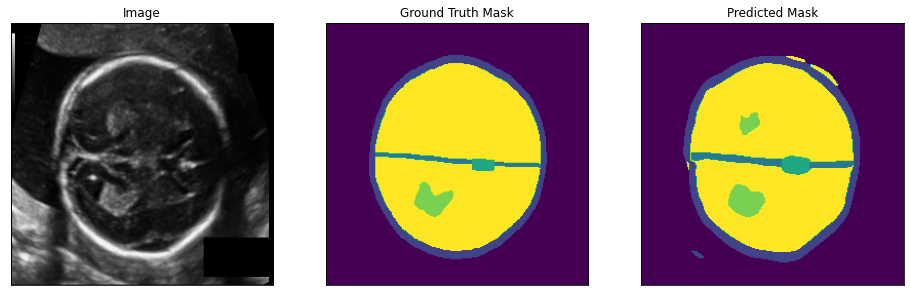

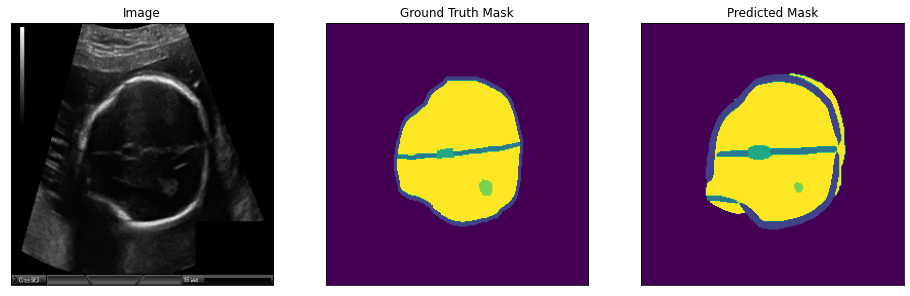

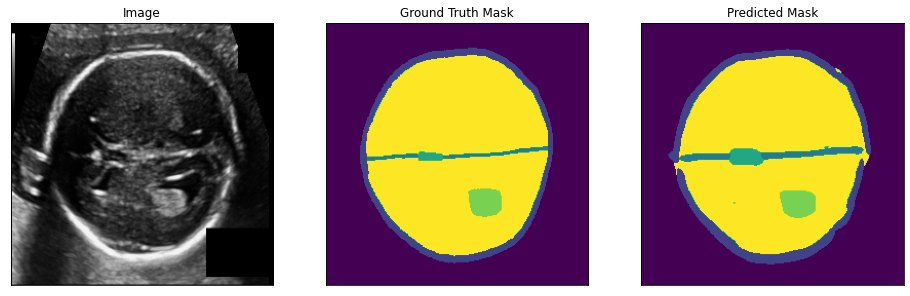

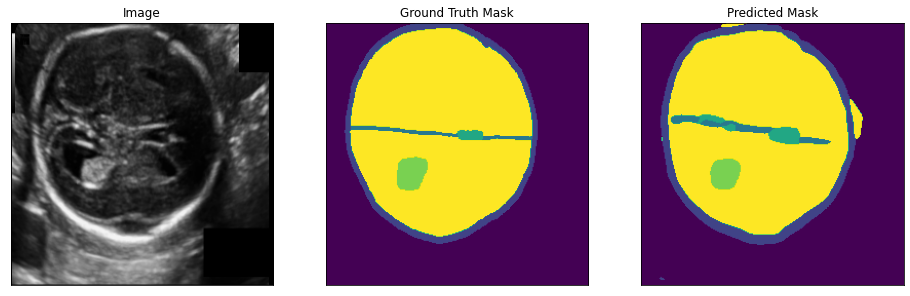

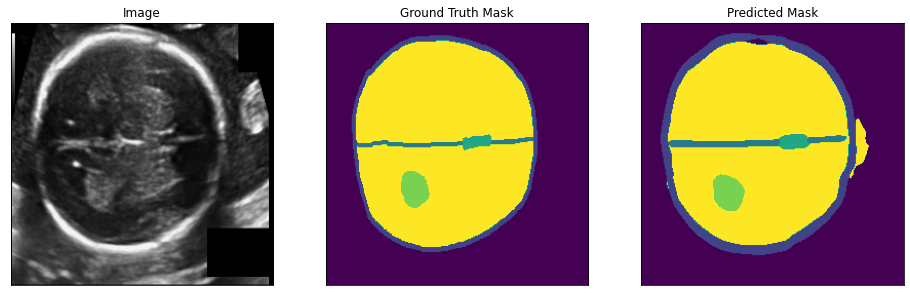

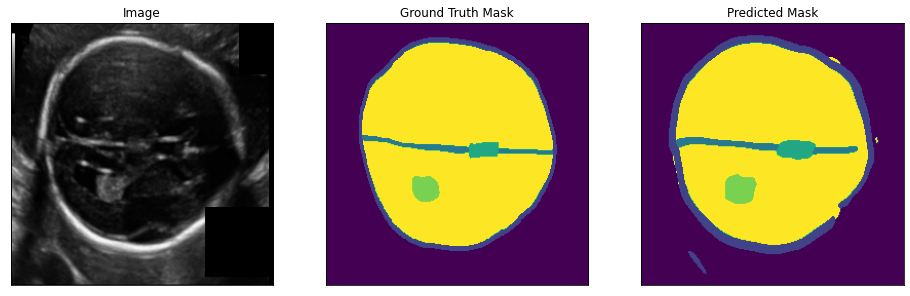

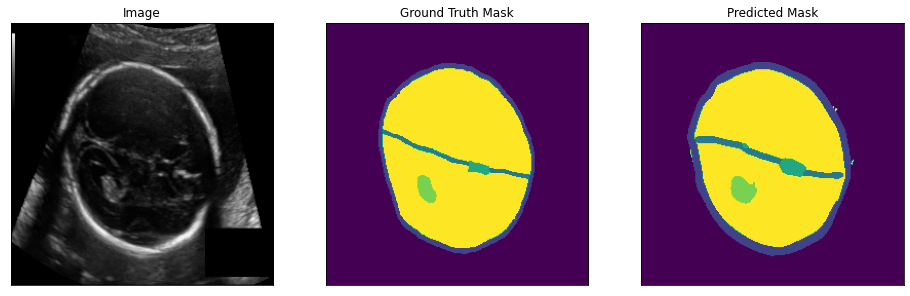

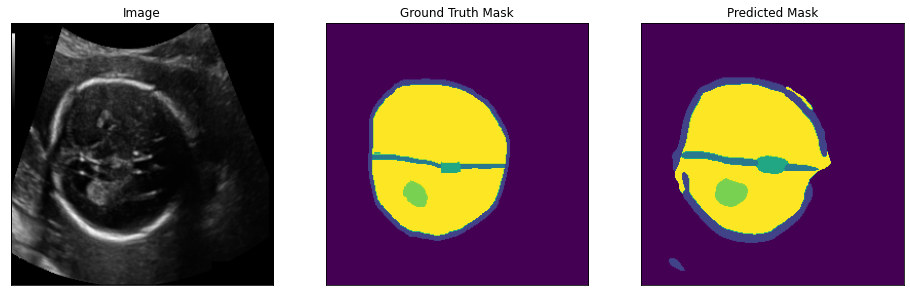

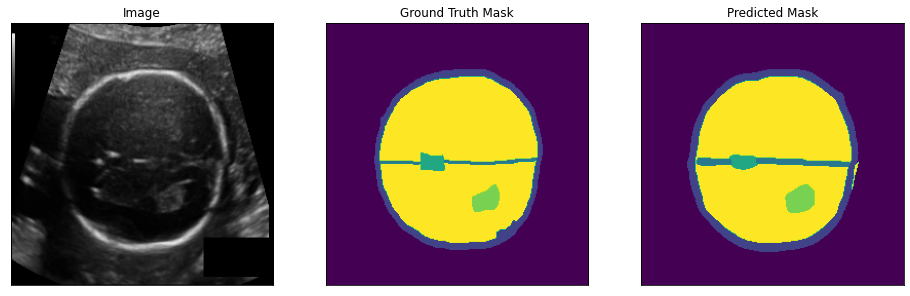

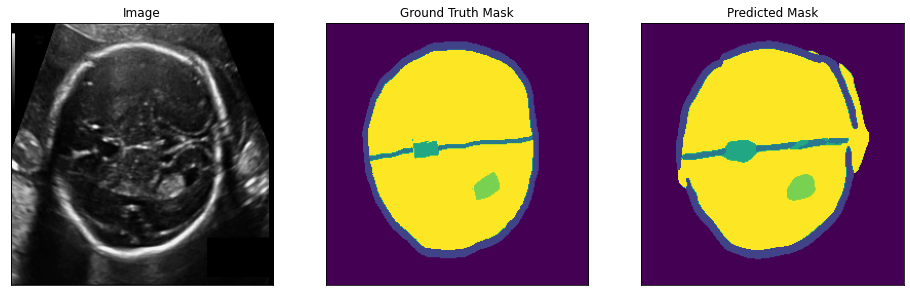

In [24]:
#PLOTTING VALIDATION IMAGES 
for i in range(len(valDS)):
    image_vis = valDS[i][0].permute(1,2,0)
    image_vis = image_vis.numpy()*255
    image_vis = image_vis.astype('uint8')
    image, gt_mask = valDS[i]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    m = nn.Softmax(dim=1)
    pr_probs = m(pr_mask)              
    pr_mask = torch.argmax(pr_probs, dim=1).squeeze(1)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis,
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

PLOTTING AND SAVING TEST IMAGES

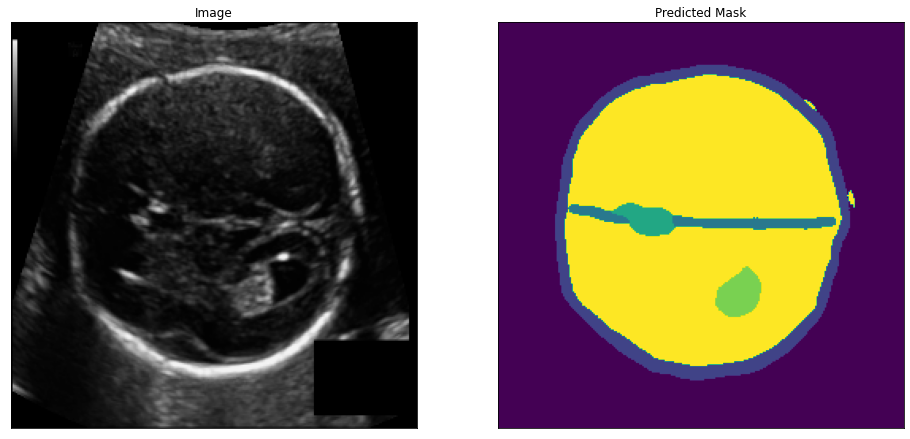

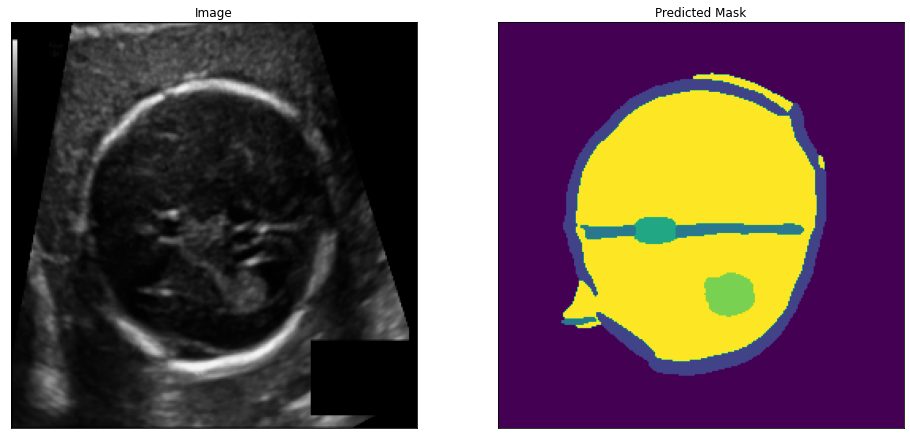

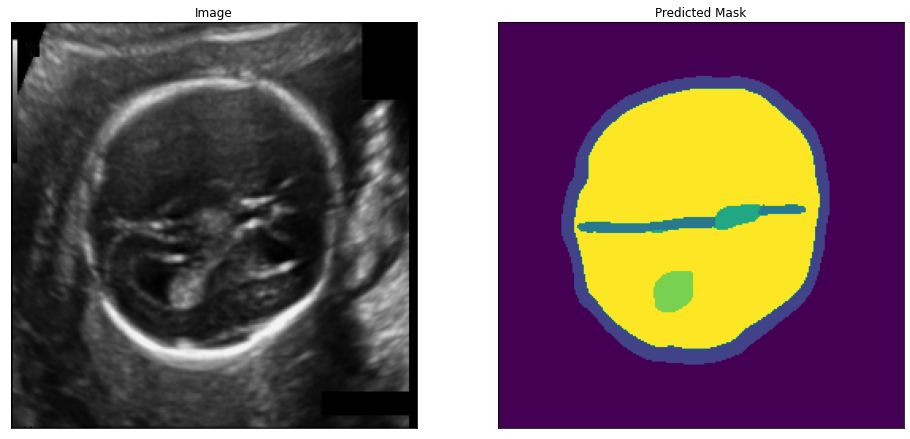

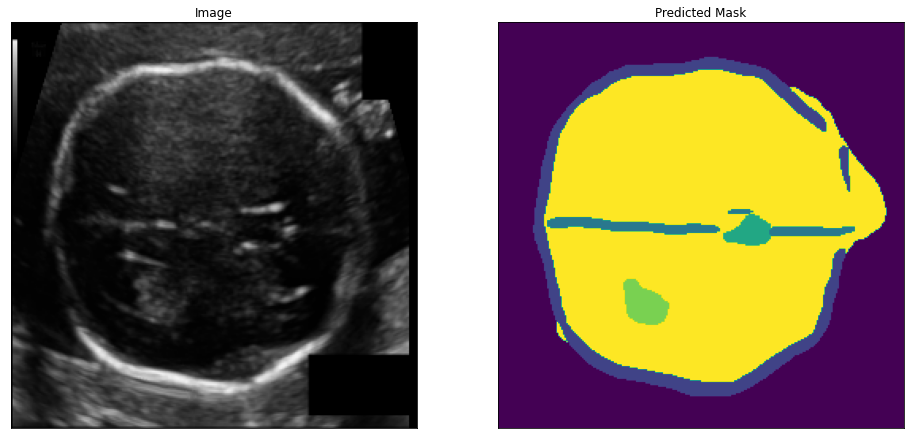

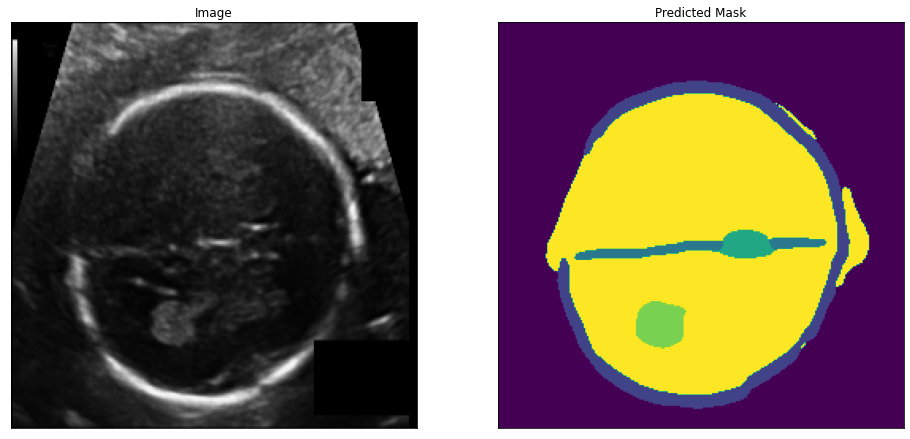

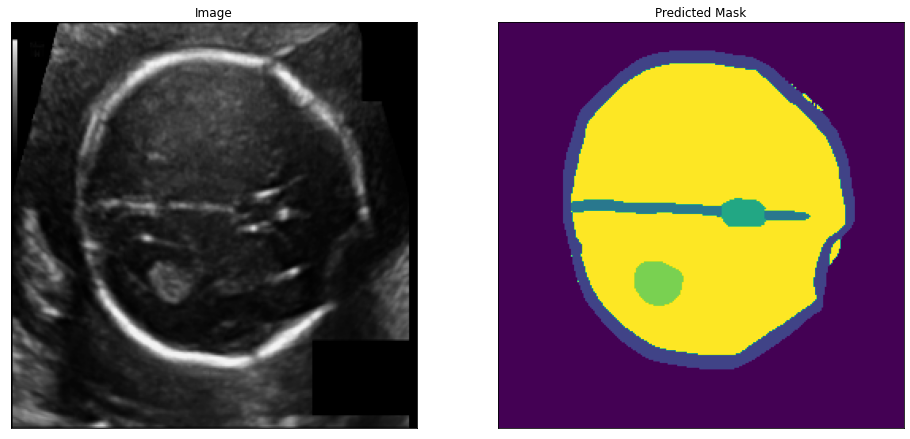

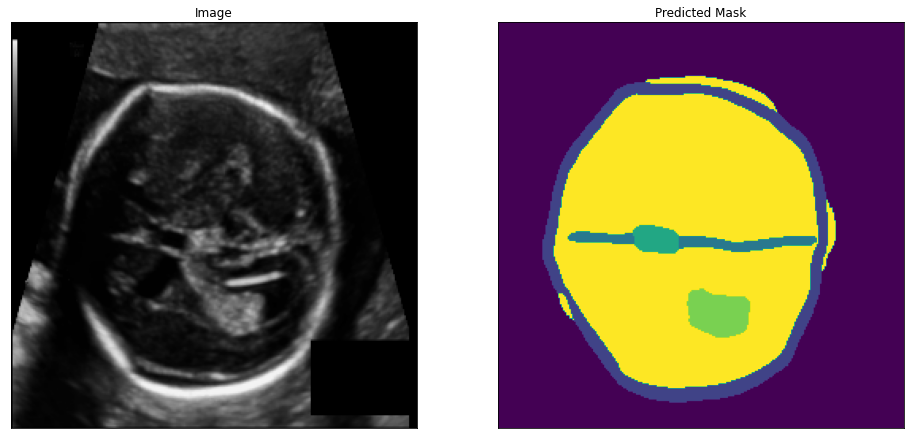

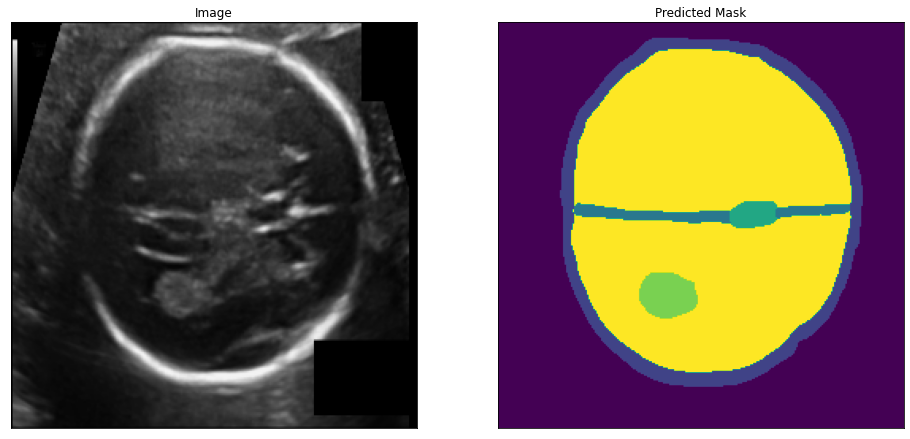

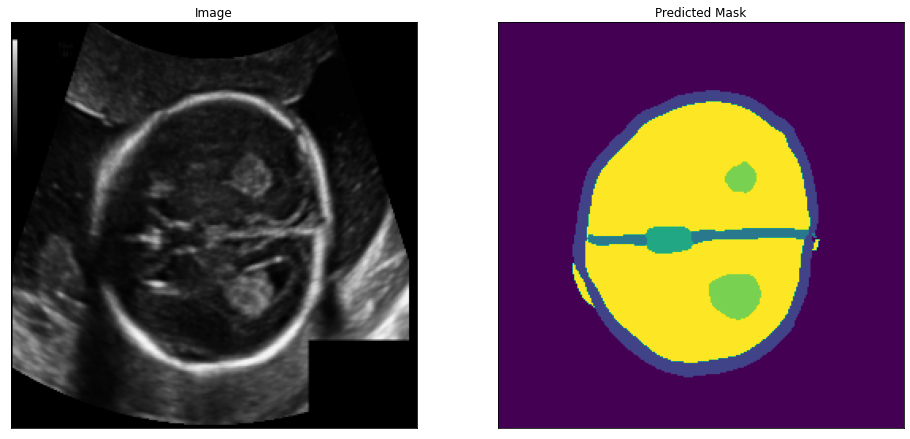

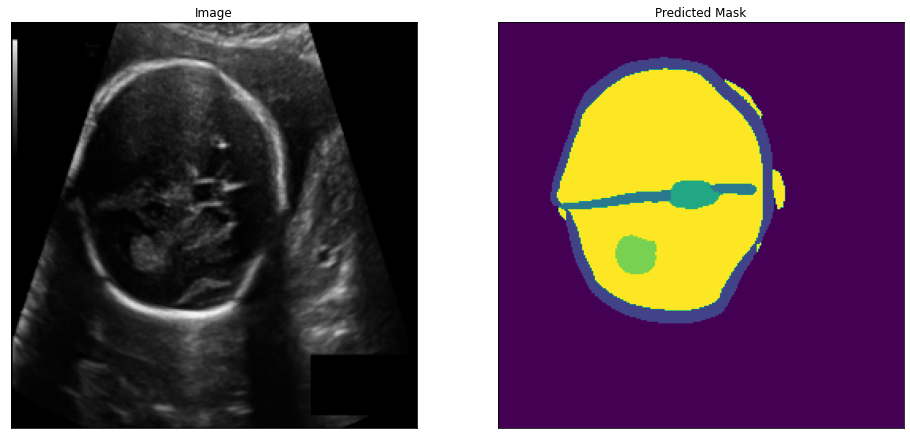

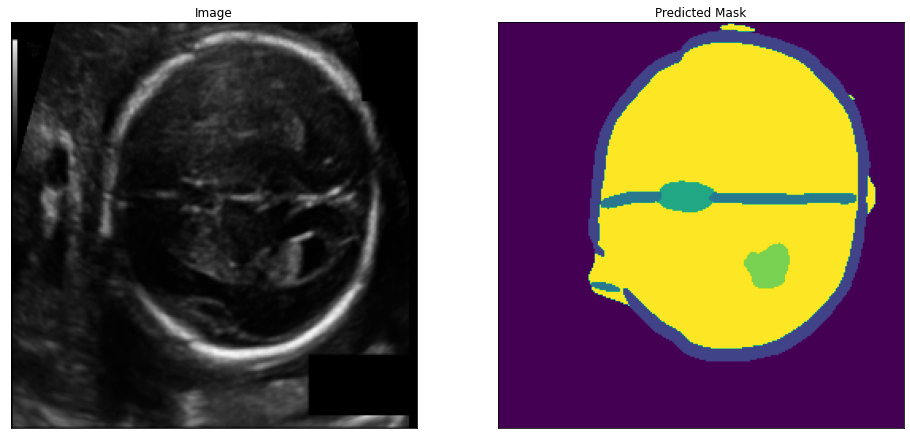

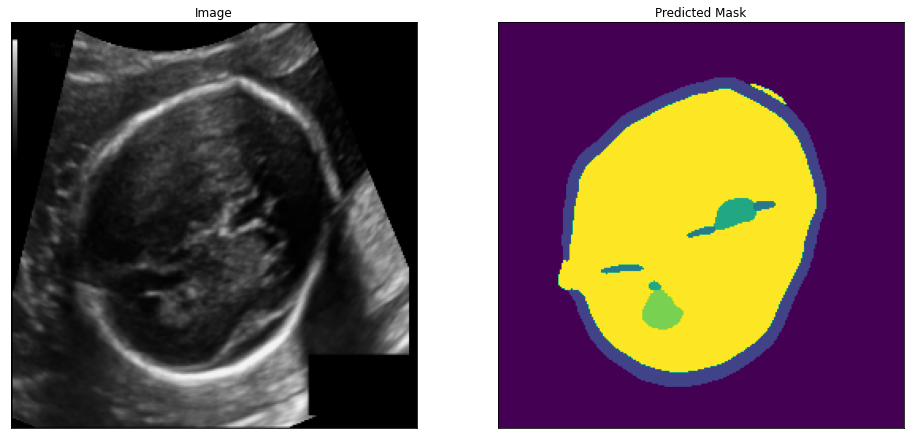

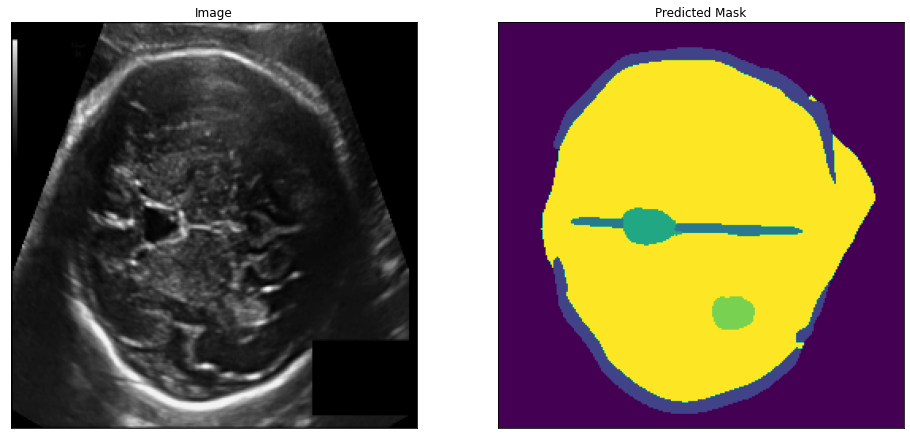

In [25]:
test_path = '/content/drive/MyDrive/labels'
os.chdir(test_path)
#Plotting test images and saving test images
for i in range(len(testDS)):    
    image_vis, _ = testDS[i]
    image_vis = image_vis.permute(1,2,0)
    image_vis = image_vis.numpy()*255
    image_vis = image_vis.astype('uint8')
    image, _ = testDS[i]
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    m = nn.Softmax(dim=1)
    pr_probs = m(pr_mask)              
    pr_mask = torch.argmax(pr_probs, dim=1).squeeze(1)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    image_name = test.iloc[i,2]
    cv2.imwrite(image_name[:-4] + '_Annotation.png',pr_mask)
        
    visualize(
        image=image_vis, 
        predicted_mask=pr_mask
    )

Thank you!